**8장 – 차원 축소**

_이 노트북에는 8장의 모든 샘플 코드와 연습 문제에 대한 솔루션이 포함되어 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/08_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 8.0 설정

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

또한 Scikit-Learn ≥ 1.0.1이 필요합니다:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

이전 장에서와 마찬가지로 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'  # 기본 sans-serif 폰트 사용
plt.rcParams['axes.unicode_minus'] = False 
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

'''
import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False
'''

"\nimport sys\n# 코랩의 경우 나눔 폰트를 설치합니다.\nif 'google.colab' in sys.modules:\n    !sudo apt-get -qq -y install fonts-nanum\n    import matplotlib.font_manager as fm\n    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])\n    for fpath in font_files:\n        fm.fontManager.addfont(fpath)\n\n# 나눔 폰트를 사용합니다.\nimport matplotlib\n\nmatplotlib.rc('font', family='NanumBarunGothic')\nmatplotlib.rcParams['axes.unicode_minus'] = False\n"

그리고 `images/dim_reduction` 폴더를 만들고(아직 존재하지 않는 경우), 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [10]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 8.3 PCA

이 장에서는 PCA와 매니폴드 학습의 개념을 설명하기 위해 몇 가지 그림으로 시작합니다. 아래는 이러한 그림을 생성하는 코드입니다. 원하는 경우 아래의 [주성분](#Principal-Components) 섹션으로 바로 건너뛸 수 있습니다.

작은 3D 데이터 집합을 생성해 보겠습니다. 타원형이고 3D 공간에서 회전하며 점들이 고르지 않게 분포되어 있고 노이즈가 상당히 많은 데이터입니다:

In [8]:
# 추가 코드

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # 3D 데이터 초기화
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # 고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # 타원형
X += 0.28 * np.random.randn(m, 3)  # 노이즈 추가
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # 약간 이동

투영 평면과 함께 3D 데이터셋을 그립니다.

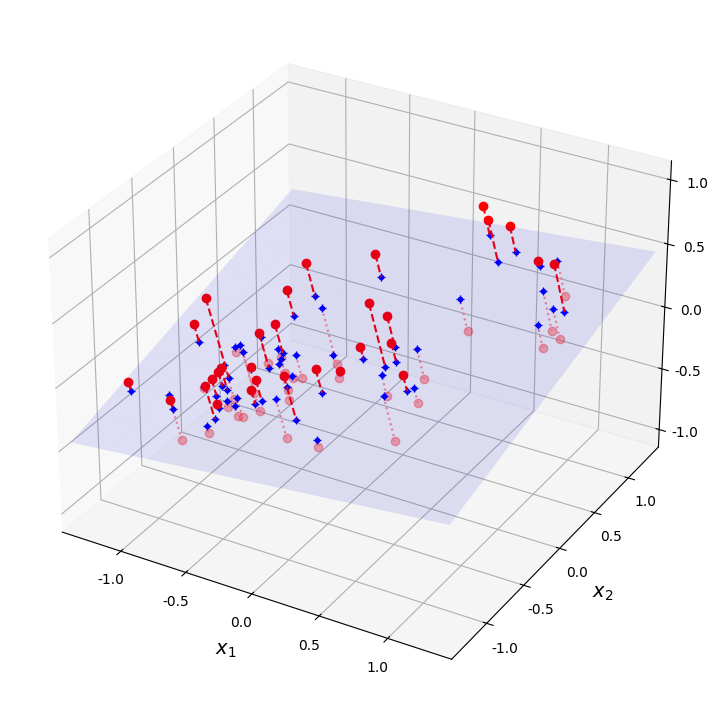

In [11]:
# 추가 코드 - 이 셀은 그림 8-2를 생성하고 저장합니다.

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # 2D로 축소된 데이터셋
X3D_inv = pca.inverse_transform(X2D)  # 투영된 샘플의 3D 위치
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # 투영 평면의 계수
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # 평면
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # 평면 위의 샘플
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # 평면 아래 샘플

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# 평면 아래에 샘플과 투영선을 먼저 그립니다.
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # 투영 평면
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # 투영 샘플
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# 이제 평면 위 샘플과 투영선을 그립니다.
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

save_fig("dataset_3d_plot", tight_layout=False)
plt.show()

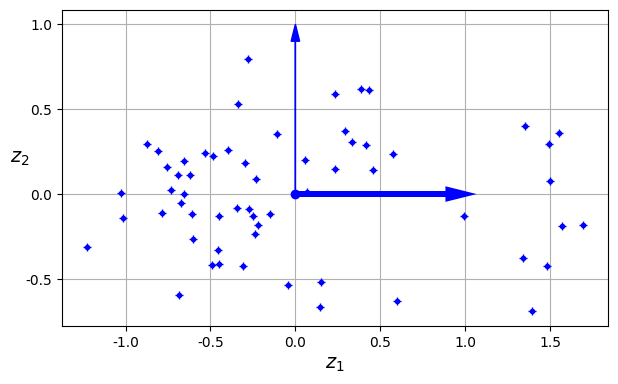

In [12]:
# 추가 코드 - 이 셀은 그림 8-3을 생성하고 저장합니다.

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)
save_fig("dataset_2d_plot")

In [13]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

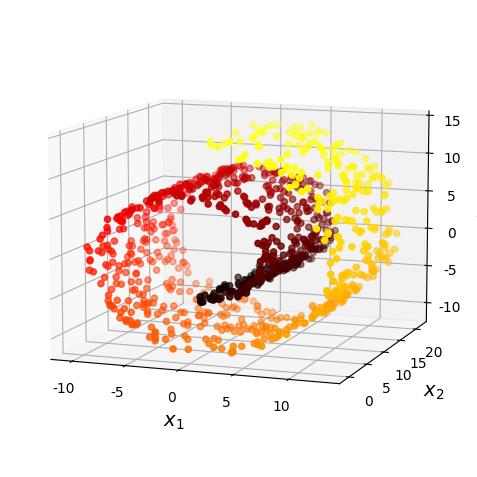

In [14]:
# 추가 코드 - 이 셀은 그림 8-4를 생성하고 저장합니다.

from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
save_fig("swiss_roll_plot")
plt.show()

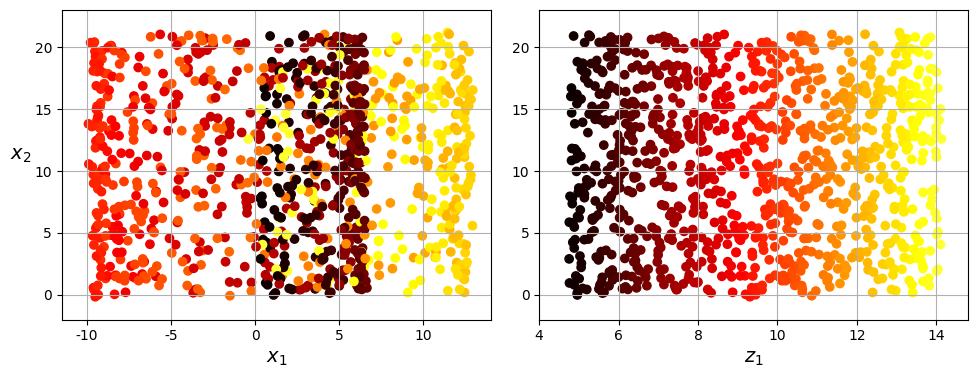

In [10]:
# 추가 코드 - 이 셀은 그림 8-5에 대한 플롯을 생성하고 저장합니다.

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

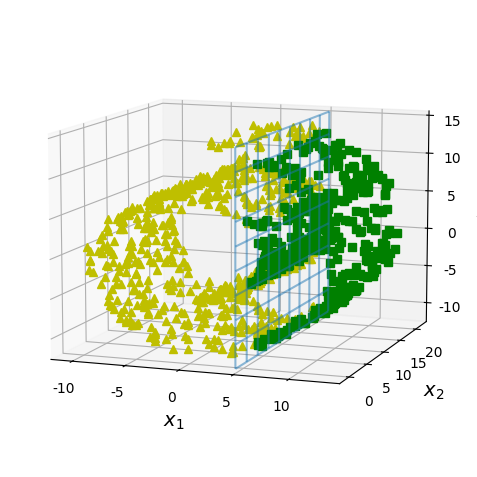

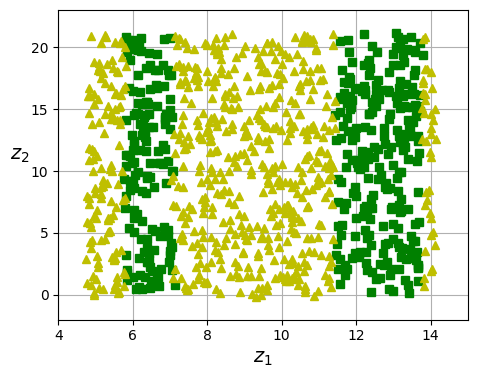

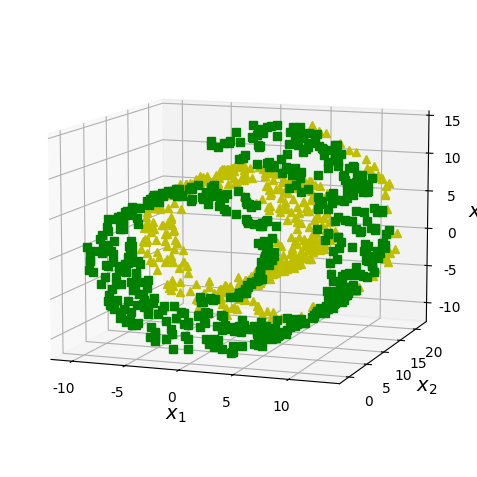

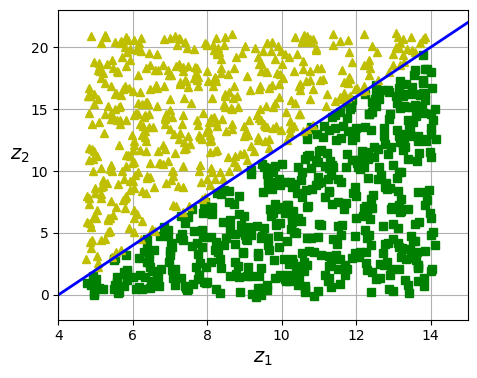

In [11]:
# 추가 코드 - 이 셀은 그림 8-6에 대한 플롯을 생성하고 저장합니다.

axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)
save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("manifold_decision_boundary_plot2")
plt.show()

positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("manifold_decision_boundary_plot4")
plt.show()

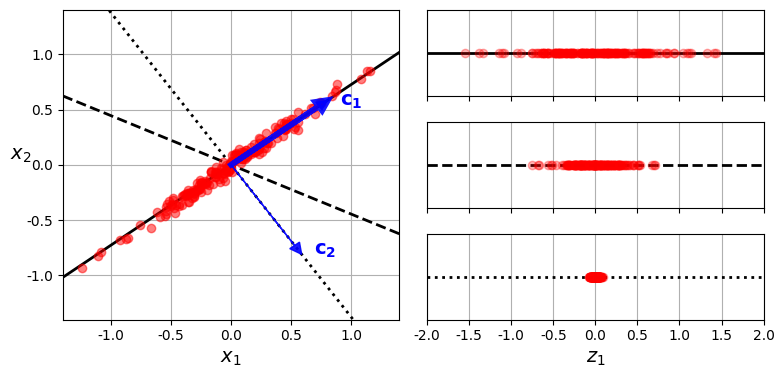

In [12]:
# 추가 코드 - 이 셀은 그림 8-7을 생성하고 저장합니다.

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # 스트레치
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # 회전

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()

save_fig("pca_best_projection_plot")
plt.show()

## 8.3.2 Principal Components

In [13]:
# 슬라이드 51
import numpy as np
from scipy.spatial.transform import Rotation

# 이 노트북의 앞부분에서 생성한 작은 3D 데이터셋
m = 60
X = np.zeros((m, 3))  # 3D 데이터 초기화
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # 고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # 타원형
X += 0.28 * np.random.randn(m, 3)  # 노이즈 추가
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # 약간 이동

X_centered = X - X.mean(axis=0)
u, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]


In [14]:
c1

array([0.67857588, 0.70073508, 0.22023881])

In [15]:
c2

array([-0.72817329,  0.6811147 ,  0.07646185])

참고: 원칙적으로 SVD 인수 분해 알고리즘은 **X** = **UΣV**<sup>⊺</sup>인 세 개의 행렬 **U**, **Σ**, **V**을 반환합니다. **U**는 _m_ × _m_ 행렬, **Σ**는 _m_ × _n_ 행렬, **V**는 _n_ × _n_ 행렬입니다. 그러나 `svd()` 함수는 대신 **U**, **s** 및 **V**<sup>⊺</sup>를 반환합니다. **s**는 **Σ**의 상위 _n_ 행의 주 대각선에 있는 모든 값을 포함하는 벡터입니다. 다른 곳에서는 **Σ**가 0으로 가득 차 있기 때문에 **s**로부터 다음과 같이 쉽게 재구성할 수 있습니다:

In [16]:
# 추가 코드 - s에서 Σ를 구성하는 방법을 보여줍니다.
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

## 8.3.3 d 차원으로 투영하기

In [17]:
# W2    Slide 52
W2 = Vt[:2].T
X2D = X_centered @ W2

## 8.3.4 사이킷런 사용하기

사이킷런을 사용하면 PCA는 정말 간단합니다. 중심을 평균에 맞추는 것까지 자동으로 처리합니다:

In [18]:
# PCA ... Slide 53
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [19]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

## 8.3.5 설명된 분산의 비율

이제 설명된 분산 비율을 살펴보겠습니다:

In [20]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

첫 번째 차원은 분산의 약 76%를 설명하는 반면, 두 번째 차원은 약 15%를 설명합니다.

2D로 투영함으로써 약 9%의 분산이 감소했습니다:

In [21]:
1 - pca.explained_variance_ratio_.sum()  # 추가 코드

np.float64(0.09028309326742034)

## 8.3.6 적절한 차원 수 선택하기

In [22]:
from sklearn.datasets import fetch_openml

# 사이킷런 1.4버전에서 parser 매개변수 기본값이 'liac-arff'에서 'auto'로 바뀌었습니다.
# 이전 버전에서도 동일한 결과를 내도록 명시적으로 'auto'로 지정합니다.

mnist = fetch_openml('mnist_784',as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1


In [23]:
d

np.int64(154)

In [24]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [25]:
pca.n_components_

np.int64(154)

In [26]:
pca.explained_variance_ratio_.sum()  # 추가 코드

np.float64(0.9501960192613035)

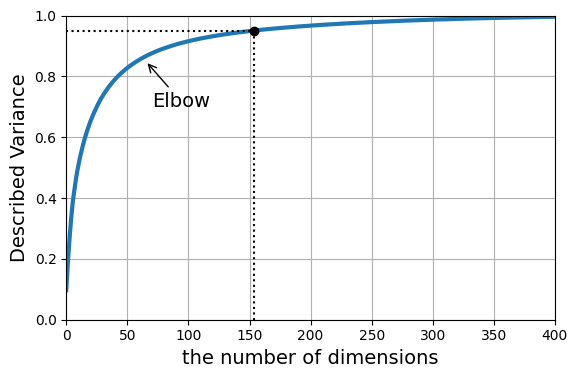

In [27]:
# 추가 코드 - 이 셀은 그림 8-8을 생성하고 저장합니다.

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("the number of dimensions")
plt.ylabel("Described Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [28]:
# 슬라이드 58
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    PCA(random_state=42),
    RandomForestClassifier(random_state=42)
)

param_dist = {
    "pca__n_components" : np.arange(10, 80),
    "randomforestclassifier__n_estimators" : np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(clf, param_dist,n_iter=10,cv=3,random_state=42)
rnd_search.fit(X_train[:1000],y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [29]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': np.int64(475), 'pca__n_components': np.int64(57)}


In [31]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 50)}
grid_search = GridSearchCV(clf, param_grid, cv=2)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49])})

In [32]:
grid_search.best_params_

{'pca__n_components': np.int64(49)}

## 8.3.7 압축을 위한 PCA

In [33]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [34]:
X_recovered = pca.inverse_transform(X_reduced)

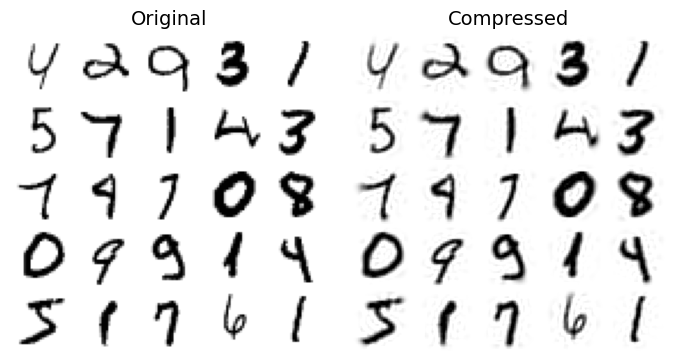

In [35]:
# extra code – this cell generates and saves Figure 8–9

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

save_fig("mnist_compression_plot")

## 8.3.8 랜덤 PCA

In [36]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## 8.3.9 점진적 PCA

In [37]:
# IncrementalPCA ... Slide 62
from sklearn.decomposition import IncrementalPCA
n_batches = 100

inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train,n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)


**넘파이 `memmap` 클래스 사용 – 디스크의 이진 파일에 저장된 배열에 메모리 매핑하기**

`memmap` 인스턴스를 생성하고, MNIST 훈련 세트를 복사한 다음, `flush()`를 호출하여 캐시에 남아 있는 모든 데이터를 디스크에 저장해 보겠습니다. 이 작업은 일반적으로 첫 번째 프로그램에서 수행합니다:

In [38]:
# 대신 루프를 사용하여 데이터를 청크 단위로 저장할 수 있습니다.
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32',mode='write',shape=X_train.shape)
X_mmap[:] = X_train
X_mmap.flush()

그런 다음 다른 프로그램이 데이터를 로드하여 학습에 사용합니다:

In [39]:
# X_mmap = ...
X_mmap = np.memmap(filename,dtype='float32',mode='readonly').reshape(-1,784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154,batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

# 8.4 랜덤 투영

**경고**: 이 섹션에서는 약 2.5GB의 RAM을 사용합니다. 컴퓨터 메모리가 부족하면 _m_과 _n_을 줄이세요:

In [2]:
# johnson_lindenstrauss_min_dim
from sklearn.random_projection import johnson_lindenstrauss_min_dim
import numpy as np
m, ε = 5_000, 0.1

d = johnson_lindenstrauss_min_dim(m, eps= ε)
d

np.int64(7300)

In [3]:
# 추가 코드 - johnson_lindenstrauss_min_dim으로 계산한 방정식
d = int(4 * np.log(m) / (ε ** 2 / 2 - ε ** 3 / 3))
d

7300

In [4]:
n = 10_000  # 20,000 원래
np.random.seed(42)

P = np.random.randn(d, n) / np.sqrt(d)  # 표준 편차 조정
X = np.random.randn(m, n)  # 가짜 데이터셋 생성
X_reduced = X @ P.T


In [5]:
# GaussianRandomProjection
from sklearn.random_projection import GaussianRandomProjection
# 위와 동일한 결과
gaussian_rnd_proj = GaussianRandomProjection(eps = ε,random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)

**경고**, 다음 셀을 실행하는 데 몇 분 정도 걸릴 수 있습니다:

In [6]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

In [8]:
# 추가 코드 – Gaussian과 Sparse RP 사이의 성능 비교

from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
1.61 s ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
1.39 s ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
8.13 s ± 350 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
2.05 s ± 52.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 8.5 LLE (Locally Linear Embedding) - 지역 선형 임베딩

In [10]:
# make_swiss_roll ... Slide 65
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding
X_swiss, t = make_swiss_roll(
    n_samples=1000,
    noise=0.2,
    random_state=42
)

lle = LocallyLinearEmbedding(
    n_components=2,
    n_neighbors=10,
    random_state=42
)
X_unrolled = lle.fit_transform(X_swiss)


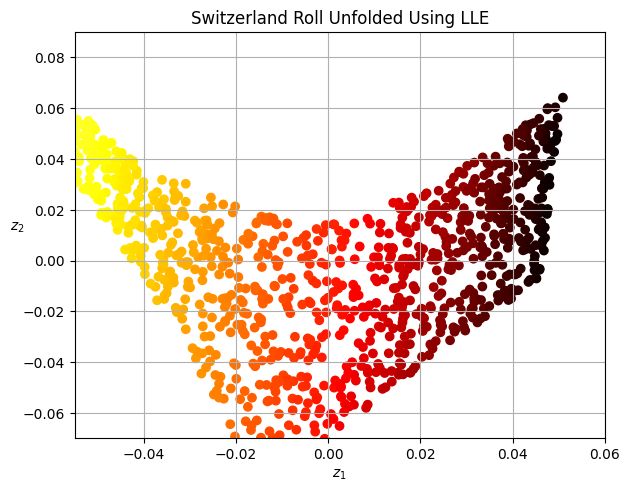

In [11]:
# 추가 코드 - 이 셀은 그림 8-10을 생성하고 저장합니다.

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.title("Switzerland Roll Unfolded Using LLE")
plt.show()

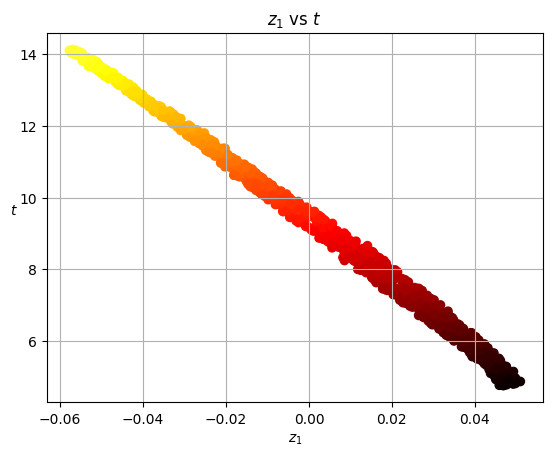

In [12]:
# 추가 코드 - z1이 t와 얼마나 잘 연관되어 있는지 보여줍니다: LLE가 잘 작동했습니다.
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

In [13]:
from sklearn.manifold import MDS

# 사이킷런 1.4버전에서 normalized_stress 매개변수의 기본값이 False에서 "auto"로 변경됩니다.
# 동일한 결과를 유지하도록 명시적으로 False로 지정합니다.
mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [14]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

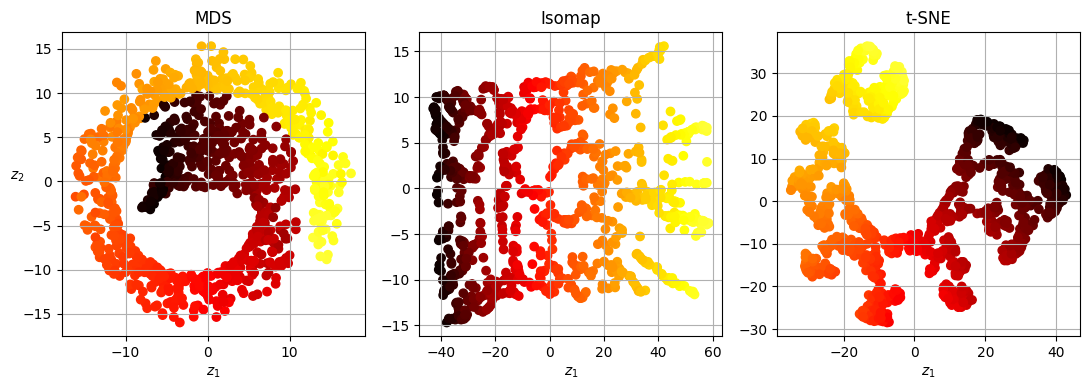

In [16]:
# 추가 코드 - 이 셀은 그림 8-11을 생성하고 저장합니다.

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

# 추가 자료 – Kernel PCA

In [2]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced = rbf_pca.fit_transform(X_swiss)

NameError: name 'X_swiss' is not defined

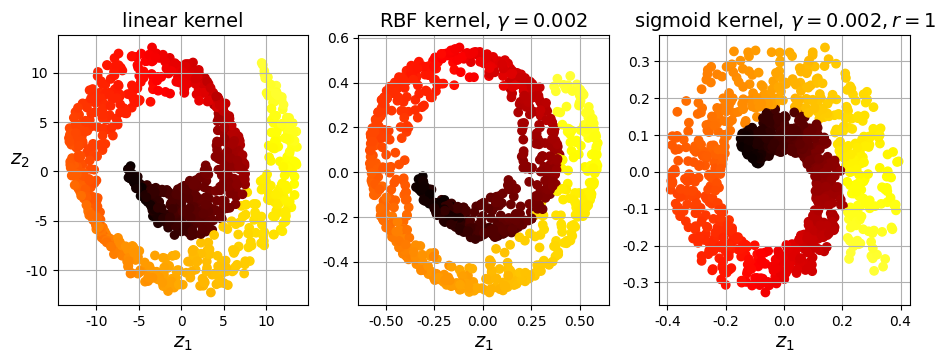

In [16]:
lin_pca = KernelPCA(kernel="linear")
rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.002, coef0=1)

kernel_pcas = ((lin_pca, "linear kernel"),
               (rbf_pca, rf"RBF kernel, $\gamma={rbf_pca.gamma}$"),
               (sig_pca, rf"sigmoid kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$"))

plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid()

plt.show()

# 연습문제 해답

## 1. to 8.

부록 A 참조

## 9.

문제: _(3장에서 소개한) MNIST 데이터셋을 로드하고 훈련 세트와 테스트 세트로 분할합니다(처음 60,000개는 훈련을 위한 샘플이고 나머지 10,000개는 테스트용입니다)._

MNIST 데이터 세트는 이전에 로드되었습니다.

In [52]:
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]

X_test = mnist.data[60000:]
y_test = mnist.target[60000:]

문제: _이 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 시간을 잰 다음, 테스트 세트로 만들어진 모델을 평가합니다._

In [53]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
%time rnd_clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

문제: _그런 다음 PCA를 사용해 설명된 분산이 95%가 되도록 차원을 축소합니다._

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

문제: _이 축소된 데이터셋에 새로운 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 확인합니다. 훈련 속도가 더 빨라졌나요?_

In [ ]:
rnd_clf_with_pca = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf_with_pca.fit(X_train_reduced, y_train)

훈련이 실제로 두 배 정도 느려졌습니다! 어떻게 그럴 수 있을까요? 이 장에서 살펴본 것처럼 차원 축소가 항상 훈련 시간 단축으로 이어지는 것은 아니며 데이터셋, 모델 및 훈련 알고리즘에 따라 달라집니다. 그림 8-6(위의 `manifold_decision_boundary_plot*` 플롯)을 참조하세요. `RandomForestClassifier` 대신 `SGDClassifier`를 사용해 보면, PCA를 사용할 때 훈련 시간이 3배 정도 단축되는 것을 알 수 있습니다. 사실 이 작업은 잠시 후에 하겠지만, 먼저 새로운 랜덤 포레스트 분류기의 정밀도를 확인해 보겠습니다.

문제: _이제 테스트 세트에서 이 분류기를 평가해보세요. 이전 분류기와 비교해서 어떤가요?_

In [ ]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

차원을 줄일 때 잠재적으로 유용한 신호가 일부 손실되기 때문에 성능이 약간 저하되는 것이 일반적입니다. 그러나 이 경우에는 성능 저하가 다소 심각합니다. 따라서 PCA는 학습 속도를 늦추고 성능을 저하시키는 등 실제로 도움이 되지 않았습니다. 😭

문제: _`SGDClassifier`로 다시 시도해 보세요. PCA가 얼마나 도움이 되나요?_

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train, y_train)

In [ ]:
y_pred = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

좋아, `SGDClassifier`는 이 데이터셋에서 `RandomForestClassifier`보다 훈련하는 데 훨씬 더 오래 걸리고 테스트 세트에서 성능이 더 나쁩니다. 하지만 지금 우리가 관심 있는 것은 그런 것이 아니라 PCA가 `SGDClassifier`에 얼마나 도움이 될 수 있는지 보고 싶습니다. 축소된 데이터 세트를 사용하여 훈련해 봅시다:

In [ ]:
sgd_clf_with_pca = SGDClassifier(random_state=42)
%time sgd_clf_with_pca.fit(X_train_reduced, y_train)

멋지네요! 차원을 줄이면 속도가 약 5배 빨라졌습니다. :)  모델의 정확도를 확인해 봅시다:

In [ ]:
y_pred = sgd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

훌륭합니다! PCA는 속도를 5배 향상시켰을 뿐만 아니라 성능도 약간 개선했습니다.

여기까지입니다: PCA는 엄청난 속도 향상과 운이 좋으면 성능 향상을 가져올 수 있습니다.... 하지만 보장되지는 않습니다. 모델과 데이터 세트에 따라 다릅니다!

## 10.

문제: _t-SNE 알고리즘을 사용해 MNIST 데이터셋의 처음 5,000개 이미지를 2차원으로 축소시키고 맷플롯립으로 그래프를 그려보세요. 이미지의 타깃 클래스마다 10가지 색상으로 나타낸 산점도를 그릴 수 있습니다._

작업 속도를 높이기 위해 MNIST 훈련 세트의 첫 5,000개 이미지로 제한해 보겠습니다.

In [63]:
X_sample, y_sample = X_train[:5000], y_train[:5000]

데이터 집합을 그래프로 그릴 수 있도록 t-SNE를 사용하여 차원을 2D로 줄여 보겠습니다:

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
%time X_reduced = tsne.fit_transform(X_sample)

이제 Matplotlib의 `scatter()` 함수를 사용하여 각 숫자에 대해 다른 색상을 사용하여 산점도를 그려 보겠습니다:

In [ ]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

정말 아름답지 않나요? :) t-SNE에 타깃이 주어지지 않았음에도 불구하고 대부분의 숫자가 다른 숫자와 잘 분리되어 있습니다. 유사한 이미지의 클러스터를 식별했습니다. 하지만 여전히 약간 겹치는 부분이 있습니다. 예를 들어, 3과 5가 많이 겹치고(그래프의 오른쪽) 4와 9도 겹칩니다(오른쪽 상단 모서리).

숫자 4와 9에만 집중해 보겠습니다:

In [ ]:
plt.figure(figsize=(9, 9))
cmap = plt.cm.jet
for digit in ('4', '9'):
    plt.scatter(X_reduced[y_sample == digit, 0], X_reduced[y_sample == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

이 두 개의 숫자만으로 t-SNE를 실행하여 더 멋진 이미지를 만들 수 있는지 확인해 보겠습니다:

In [67]:
idx = (y_sample == '4') | (y_sample == '9')
X_subset = X_sample[idx]
y_subset = y_sample[idx]

tsne_subset = TSNE(n_components=2, init="random", learning_rate="auto",
                   random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

In [ ]:
plt.figure(figsize=(9, 9))
for digit in ('4', '9'):
    plt.scatter(X_subset_reduced[y_subset == digit, 0],
                X_subset_reduced[y_subset == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

여전히 약간 겹치기는 하지만 훨씬 나아졌습니다. 4가 9처럼 보이거나 그 반대의 경우도 있을 수 있습니다. 이 그래프의 각 영역에서 몇 개의 숫자를 시각화하여 무슨 일이 일어나고 있는지 이해할 수 있다면 좋을 것입니다. 실제로 지금 그렇게 해보겠습니다.

문제: _또는 산점도의 각 포인트를 이에 상응하는 샘플의 클래스(0에서 9까지 숫자)로 바꾸거나 숫자 이미지 자체의 크기를 줄여서 그릴 수도 있습니다(모든 숫자를 다 그리면 그래프가 너무 복잡해지므로 무작위로 선택한 샘플만 그리거나, 인접한 곳에 다른 샘플이 그려져 있지 않은 경우에만 그립니다). 잘 분리된 숫자의 군집을 시각화할 수 있을 것입니다._

(위의 산점도와 유사한) 산점도를 그리고 최소한의 거리를 띄고 여러 색깔로 숫자를 쓰는 `plot_digits()` 함수를 만들어 보겠습니다. 숫자 이미지가 제공되면 그 이미지가 대신 그려집니다. 이 구현은 사이킷런의 훌륭한 예제 중 하나(다른 숫자 데이터셋을 사용한 [plot_lle_digits](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html))에서 영감을 얻었습니다.

In [69]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    # 입력 특성의 스케일을 0에서 1까지로 조정해 보겠습니다.
    X_normalized = MinMaxScaler().fit_transform(X)
    # 이제 지금까지 그린 숫자의 좌표 목록을 만듭니다.
    # 아래 루프에서 `if` 문을 피하기 위해 시작할 때 이미 멀리 떨어져 있는 것으로 가정합니다.
    neighbors = np.array([[10., 10.]])
    # 나머지는 설명이 필요 없습니다.
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # 현재 축 가져오기
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

한번 해봅시다! 먼저 5,000개의 이미지 모두에 대해 이미지가 아닌 컬러 숫자를 표시해 보겠습니다:

In [ ]:
plot_digits(X_reduced, y_sample)

괜찮지만 그렇게 아름답지는 않습니다. 숫자 이미지로 시도해 보겠습니다:

In [ ]:
plot_digits(X_reduced, y_sample, images=X_sample, figsize=(35, 25))

더 멋지네요! 이제 4과 9에만 집중해 보겠습니다:

In [ ]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

비슷하게 생긴 4가 어떻게 그룹화되어 있는지 보세요. 예를 들어, 4는 그림의 상단에 가까워질수록 점점 더 기울어집니다. 기울어진 9도 상단에 가까워집니다. 어떤 4는 실제로 9처럼 보이기도 하고 그 반대의 경우도 있습니다.

문제: _PCA, LLE, MDS 같은 차원 축소 알고리즘을 적용해보고 시각화 결과를 비교해보세요._

PCA부터 시작하겠습니다. 소요 시간도 측정해 보겠습니다:

In [ ]:
pca = PCA(n_components=2, random_state=42)
%time X_pca_reduced = pca.fit_transform(X_sample)
plot_digits(X_pca_reduced, y_sample)
plt.show()

와, PCA는 정말 빠르네요! 하지만 몇 개의 클러스터가 보이지만 겹치는 부분이 너무 많습니다. LLE를 사용해 봅시다:

In [ ]:
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
%time X_lle_reduced = lle.fit_transform(X_sample)
plot_digits(X_lle_reduced, y_sample)
plt.show()

시간이 더 걸리지만 결과는 전혀 좋지 않습니다. 분산 95%를 보존하면서 PCA를 먼저 적용하면 어떤 결과가 나오는지 살펴봅시다:

In [ ]:
pca_lle = make_pipeline(PCA(n_components=0.95),
                        LocallyLinearEmbedding(n_components=2, random_state=42))

%time X_pca_lle_reduced = pca_lle.fit_transform(X_sample)
plot_digits(X_pca_lle_reduced, y_sample)
plt.show()

결과는 다소 나쁘지만 이번 훈련은 조금 더 빨랐습니다.

MDS를 사용해 보겠습니다:

**경고**, 다음 셀은 하드웨어에 따라 실행하는 데 약 10~30분이 소요됩니다:

In [ ]:
# 사이킷런 1.4버전에서 normalized_stress 매개변수의 기본값이 False에서 "auto"로 변경됩니다.
# 동일한 결과를 유지하도록 명시적으로 False로 지정합니다.
X_mds_reduced = MDS(n_components=2, normalized_stress=False,
                    random_state=42).fit_transform(X_sample)
plot_digits(X_mds_reduced, y_sample)
plt.show()

음. 모든 클러스터가 너무 많이 겹쳐서 보기 좋지 않습니다. PCA로 먼저 시도해 봅시다. 더 빠를까요?

**경고**, 다음 셀은 하드웨어에 따라 실행하는 데 약 10~30분이 소요됩니다:

In [ ]:
# 사이킷런 1.4버전에서 normalized_stress 매개변수의 기본값이 False에서 "auto"로 변경됩니다.
# 동일한 결과를 유지하도록 명시적으로 False로 지정합니다.
pca_mds = make_pipeline(PCA(n_components=0.95, random_state=42),
                        MDS(n_components=2, normalized_stress=False, random_state=42))

%time X_pca_mds_reduced = pca_mds.fit_transform(X_sample)
plot_digits(X_pca_mds_reduced, y_sample)
plt.show()

결과는 같고 더 빠르지는 않습니다: 이 경우 PCA는 도움이 되지 않았습니다.

이제 LDA를 사용해 보겠습니다:

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
%time X_lda_reduced = lda.fit_transform(X_sample, y_sample)
plot_digits(X_lda_reduced, y_sample, figsize=(12, 12))
plt.show()

이 방법은 매우 빠르며 처음에는 좋아 보이지만 여러 클러스터가 심하게 겹친다는 것을 알게 될 때까지는 그렇지 않습니다.

이 시합에서 t-SNE가 우승한 것은 분명하지 않나요?

오늘은 여기까지입니다. 이 장이 재미있으셨기를 바랍니다!